# Markov Chain Simulation Project

In this project I fit a Markov chain model to simulated insurance claims data. The data comes from the file ‘data – sorted.csv’ which was provided to me by my professor for a class project.

## The Situation

The Mastodon Insurance Company studies a cohort of 600 drivers, who were all below 25 years old at the start of the study. In each year the number of claims made by every driver was noted.

Mastodon operates a classification scheme with six discount levels from level 0 (no discount, ie the driver pays full premium) to level 5 (50% discount), with a 10% increase in discount at each step. A policyholder who makes no claims in a year moves up one level (unless already at level 5); a policyholder who makes 1 or more claims moves down one level (unless already at level 0).

Before the study began, the drivers were categorised using variables such as age, gender, zip code, and miles driven per year. The categories reflect Mastodon’s expectation of the level of risk associated with that driver:

+ Category A — very low risk, ie the best drivers
+ Category B — low risk
+ Category C — medium risk
+ Category D — high risk, ie the worst drivers

### The Data Set

+ The data set supplied is a .csv file.
+ The top row of the data set provided consists of headers.
+ The category in which the driver was classified is the first column of the data set, which has the header "Category".
+ The discount level in which the driver was located at the start of the study is the second column, which has the header "Initial".
+ The remaining 15 columns give the number of claims in each of the years 1 through 15 of the study.

## The Task

The aim of this project is to investigate 2 themes, explain my process as I go through my analysis in a Jupyter Notebook, and to write up my findings in the form of an Executive Summary. I will aim for a length of about 700 words, suitably illustrated with graphs produced using R as my statistical package.

## My Thinking

### Part 1

Assume that the number of claims made by a customer each year forms a sequence of independent and identically distributed random variables, with common distribution being Poisson. Assume λ is the same for all policyholders. I will be using test values for λ of [.06, .12, .18, .24, .30]. For a given policyholder, the discount level at times 0, 1, 2, ..., 15 follows a kind of time series that data scientists call a "Markov chain". 

My plan to investigate this scenario is:

+ My first step should be to calculate the transition matrix of the Markov chain, I think the best tool I have for this will be Python.
+ My second step should be to calculate the equilibrium distribution of the Markov chain. Once I have the transition matrix in Python, it will be easiest to keep working in Python for my calculations.
+ My third step should be to calculate the year-by-year (over all 16 years) average percentage of full premium paid each year; I also calculated the equilibrium matrix and therefore included the minimum at the limit. I performed these calculations in Python.
+ Lastly, I should graph the results from the third step using ggplot2 in R.


### Part 2

I will devise a new classification scheme for Mastodon that alleviates any issues with the current program. Then, I will repeat the analysis of Part 1 for my newly proposed program. Finally, I’ll explain why my program should be considered over the current program.



# My Action

Now that we've established the project, let's get coding!

# Setup

Since most of my work will be in Python, I start by importing the tried and true numpy and pandas packages, which will aid me as I perform my data analysis and import my data from the csv file.

Next I load the extension that allows me to mix R and Python in the same environment.

The last thing I do in this code block is import my dataset.

In the second code block I go into R and load in all of the packages I'll be using to make graphs and tables.

In [1]:
import numpy as np
import pandas as pd

%load_ext rpy2.ipython

data = pd.read_csv (r'C:/Users/redga/Documents/code/Markov Chain Project/data - sorted.csv')

C:\Users\redga\AppData\Roaming\Python\Python310\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R

library(ggplot2)
library(knitr)
library(kableExtra)
library(IRdisplay)
library(reshape)

# Probability Distribution: Poisson

Here I begin my anlaysis by building a function that will return the values of 3 probabilities given a particular lambda for a Poisson Distribution:
+ P(0)
+ P(1)
+ P(>1)

In [3]:
def probs(lamb, prnt):

    p_0_lam = np.exp(-lamb)
    p_1_lam = np.exp(-lamb)*lamb
    p_gt1_lam = 1 - p_0_lam - p_1_lam
    
    if prnt == True:
        print('Probability of making 0 claims given a lambda of', lamb, 'is', p_0_lam)
        print('Probability of making 1 claim given a lambda of', lamb, 'is', p_1_lam)
        print('Probability of making greater than 1 claims given a lambda of', lamb, 'is', p_gt1_lam)
    
    probs = [p_0_lam, p_1_lam, p_gt1_lam]
    return probs

# Transition Matrix

Next, I build the necessary transition matrix for the orginial scenario, given the set of probabilities I generated using the previous function.

In [4]:
def init_tmat(probs, prnt):
    
    tmat = np.zeros((6,6))
    
    tmat[0][0] = 1 - probs[0]
    tmat[0][1] = probs[0]
    
    ctr = 1
    while ctr < 5:
        tmat[ctr][ctr - 1] = 1 - probs[0]
        tmat[ctr][ctr + 1] = probs[0]
        ctr += 1
    
    tmat[5][4] = 1 - probs[0]
    tmat[5][5] = probs[0]
    
    if prnt == True:
        print(tmat)
    
    return tmat

# Calculating the Forecast Model and Equilibrium Matrices

Since the problem asks for us to find the annual average rate of Premiums paid, I needed to calculate at least 15 years worth of transition matrices. Additionally, I calculated the equilibrium matrix while I was at it.

In [5]:
def find_eqmat(tmat, prnt):
    
    out = []
    out.append(tmat)
    old = tmat
    years = 0
    diff = 10
    while diff > .0000000000001:
        
        new = np.matmul(old,tmat)
        tempdiff = new - old
       
        ctr0 = 0 
        while ctr0 < 6:
            ctr1 = 0
            while ctr1 < 6:
                tempdiff[ctr0][ctr1] = np.absolute(tempdiff[ctr0][ctr1])
                ctr1 += 1
            ctr0 += 1
        
        if years < 14:
            out.append(new)
        
        years += 1
        old = new
        
        diff = np.sum(tempdiff)
    
    out.append(new)
    
    if prnt == True:
        print(years-1)
    
    out.append(years-1)
    
    return out

# Cleanup Function

This function is just here to make my code a little easier to read and take fewer lines. It simply passes a lambda value through the previous functions and generates the initial matrix, the 15 transition matrices, and the equilibrium matrix.

In [6]:
def gen(lamb,prnt):

    return find_eqmat(init_tmat(probs(lamb,prnt),prnt),prnt)

# Initial Category Populations

This code block builds a list, init, that will hold how many people start in each level.

In [7]:
ctr0 = 0
init = []
while ctr0 < 6:
    ctr1 = 0
    temp = 0
    while ctr1 < len(data['Initial']):
        if data['Initial'][ctr1] == ctr0:
            temp += 1
        ctr1 += 1
    init.append(temp)
    ctr0 += 1

# Simulated Distribution of Levels over Time

This code block takes the transition matrices and multiplies each row by the number of constituents from the beginning of the cohort. This allows us to track the expected number of people in each level based on which level they started at.

In [8]:
def vals(init,gen):

    initmat = np.zeros((6,6))

    ctr = 0
    while ctr < len(init):
        initmat[ctr][ctr] = init[ctr]
        ctr += 1
    
    out = [initmat]
    ctr = 1
    while ctr < len(gen):
        out.append(np.matmul(initmat,gen[ctr - 1]))
        ctr += 1
    out.append(gen[-1])
        
    return out

# Average Premiums Paid as a Percentage per Year

This function takes the information gleaned from the previous code block and finds what percentage of premiums are expected to be collected each year by Mastodon Insurance and returns this information as a pandas dataframe.

In [9]:
def avg_yoy(val,disc):
    
    out = []
    ctr = 0
    while ctr < len(val) - 1:
        discmat = np.matmul(val[ctr],disc)
        num = np.sum(discmat)
        den = np.sum(val[ctr])
        avg = num / den
        if ctr < 16:
            out.append([ctr,avg])
        if ctr == 16:
            out.append([val[-1],avg])
        ctr += 1
        
    df = pd.DataFrame(out, columns = ['years', 'average'])
            
    return df

# Time to calculate

First, I build a quick function to keep my code neat. This function takes a lambda, initial populations, a discount vector for each group, and a Boolean for whether or not you would like print statements as it runs. It returns a dataframe composed of the initial matrix, the 15 transition matrices, and the equilibrium matrix.

After I build this function, I call it 5 times for each of our lambda values and store them as a series of variables.

In [10]:
def org_avgs_gen(lamb,init,disc,prnt):

    return avg_yoy(vals(init,gen(lamb,prnt)),disc)

org_disc = [1,.9,.8,.7,.6,.5]

avgs1 = org_avgs_gen(.06,init,org_disc,False)
avgs2 = org_avgs_gen(.12,init,org_disc,False)
avgs3 = org_avgs_gen(.18,init,org_disc,False)
avgs4 = org_avgs_gen(.24,init,org_disc,False)
avgs5 = org_avgs_gen(.30,init,org_disc,False)

# Graphing

In the next five code blocks I use '%%R' to run R code inline with my Python code. Each of the next five blocks are doing the same thing: Using ggplot2 to graph our results.

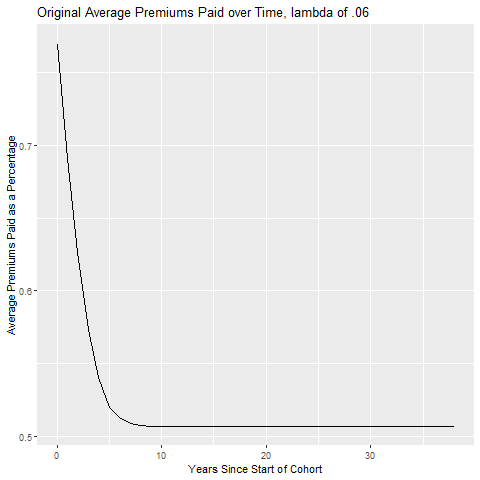

In [11]:
%%R -i avgs1 

plot1 <- ggplot(avgs1) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Original Average Premiums Paid over Time, lambda of .06') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(plot1)

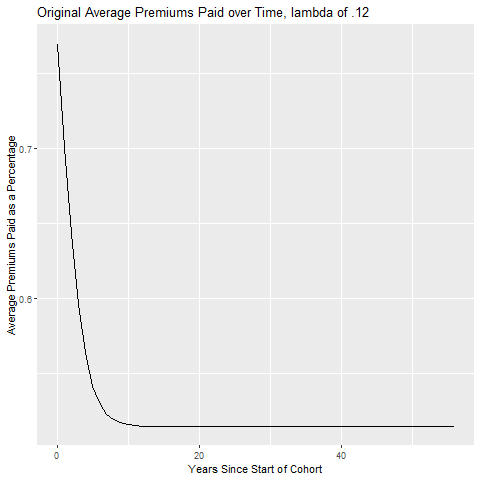

In [12]:
%%R -i avgs2

plot2 <- ggplot(avgs2) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Original Average Premiums Paid over Time, lambda of .12') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(plot2)

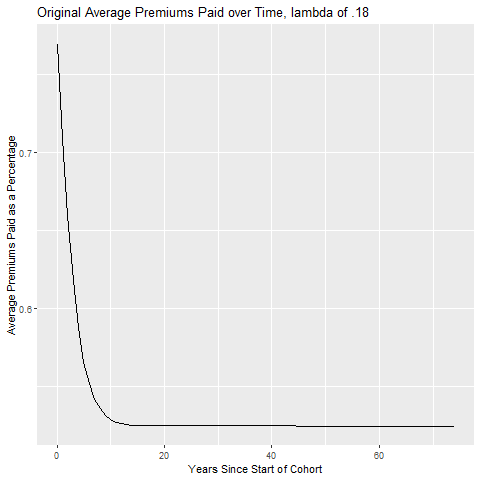

In [13]:
%%R -i avgs3

plot3 <- ggplot(avgs3) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Original Average Premiums Paid over Time, lambda of .18') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(plot3)

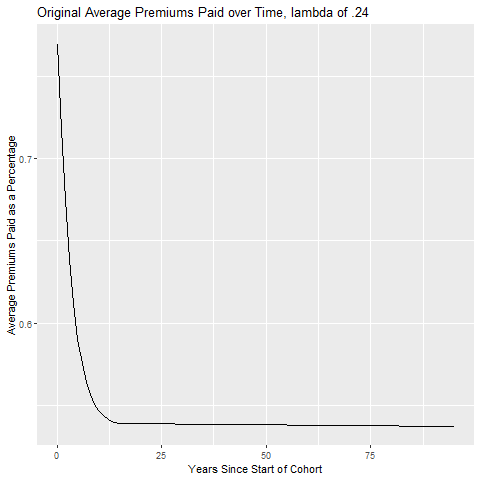

In [14]:
%%R -i avgs4

plot4 <- ggplot(avgs4) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Original Average Premiums Paid over Time, lambda of .24') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(plot4)

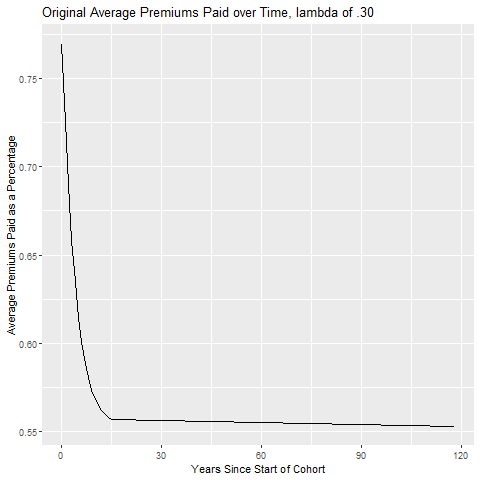

In [15]:
%%R -i avgs5

plot5 <- ggplot(avgs5) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Original Average Premiums Paid over Time, lambda of .30') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(plot5)

# The Problem with Mastodon's Program

One will notice that Mastodon is too generous with their discount because over time the average drivers’ category migrates toward just about everyone getting a big discount. That’s a problem when your forecast predicts pulling in only 51~56% of your premiums!

It's harder to see in the individual graphs, so here is a table, followed by a combined graph for comparison.




 Years   Avg, l = .06   Avg, l = .12   Avg, l = .18   Avg, l = .24   Avg, l = .30
------  -------------  -------------  -------------  -------------  -------------
     0      0.7695000      0.7695000      0.7695000      0.7695000      0.7695000
     1      0.6908692      0.7003207      0.7092218      0.7176045      0.7254990
     2      0.6260551      0.6434893      0.6598724      0.6752698      0.6897423
     3      0.5733053      0.5961466      0.6179668      0.6387358      0.6584441
     4      0.5401064      0.5642284      0.5882622      0.6118805      0.6348438
     5      0.5195638      0.5417162      0.5654663      0.5900319      0.6148063
     6      0.5128656      0.5306265      0.5519204      0.5755798      0.6006353
     7      0.5088351      0.5230239      0.5417542      0.5639988      0.5887076
     8      0.5076652      0.5195382      0.5359860      0.5565656      0.5804341
     9      0.5069664      0.5171676      0.5316855      0.5506370      0.5734894
    10      0.

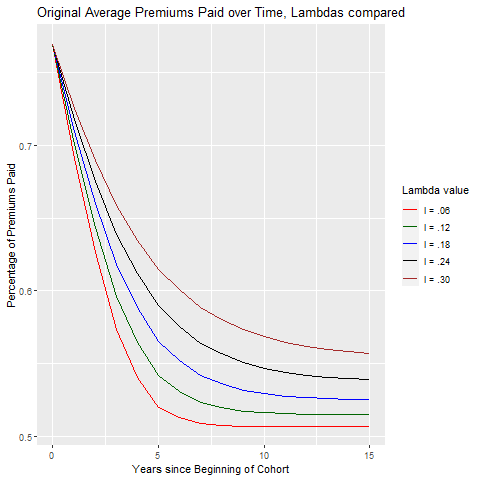

In [16]:
%%R 

avgs12 <- merge(avgs1,avgs2,by="years")
avgs34 <- merge(avgs3,avgs4,by="years")
avgs1234 <- merge(avgs12,avgs34,by="years")
avgsall <- merge(avgs1234,avgs5,by="years")

colnames(avgsall) <- c('years','l06','l12','l18','l24','l30')

orgtable <- kable(avgsall,'simple', 
            col.names = c('Years', 'Avg, l = .06', 'Avg, l = .12', 'Avg, l = .18', 'Avg, l = .24', 'Avg, l = .30'))

print(orgtable)

ggavgsall <- melt(avgsall,id.var='years')

lambs <- c('l = .06', 'l = .12', 'l = .18', 'l = .24', 'l = .30')
cols <- c('red', 'dark green', 'blue', 'black', 'brown')

plot6 <- ggplot(ggavgsall, aes(x=years, y=value, col=variable)) +
         geom_line()+
         labs(title='Original Average Premiums Paid over Time, Lambdas compared',
              x='Years since Beginning of Cohort', y='Percentage of Premiums Paid',
              col='Lambda value') +
        scale_color_manual(labels = lambs, values = cols)
print(plot6)

# On to Part II!

Now that I've demonstrated the issues with the previous system, I set about ameliorating some of the problem.

In this first code block I develop our new transition matrix. My plan moving forward is to penalize drivers who make more than one claim in a year by moving them down two levels. Since we're now moving down two levels if there's more than one accident we need a slightly different approach to building our transition matrix.

In [17]:
def rev_tmat(probs, prnt):
    
    tmat = np.zeros((6,6))
    
    tmat[0][0] = 1 - probs[0]
    tmat[0][1] = probs[0]
    
    tmat[1][0] = 1 - probs[0]
    tmat[1][2] = probs[0]
    
    ctr = 2
    while ctr < 5:
        tmat[ctr][ctr - 2] = probs[2]
        tmat[ctr][ctr - 1] = probs[1]
        tmat[ctr][ctr + 1] = probs[0]
        ctr += 1
    
    tmat[5][4] = 1 - probs[0]
    tmat[5][5] = probs[0]
    
    if prnt == True:
        print(tmat)
    
    return tmat

# Time to Calculate: Part II

Now that we have the new transition matrix, I aslo want to adjust the discount levels. Once we adjust the transition matrix and discount levels, all we have to do is the same calculation we did before, but with the new transition matrix and the new discount scheme. 'rev_gen' and 'rev_avgs_gen' are the revised versions of the previous functions we've used. 'rev_disc' is the revised discount scheme. 

The five variables I built are the dataframes we'll be graphing in the next section.

In [18]:
def rev_gen(lamb,prnt):

    return find_eqmat(rev_tmat(probs(lamb,prnt),prnt),prnt)

def rev_avgs_gen(lamb,init,disc,prnt):

    return avg_yoy(vals(init,rev_gen(lamb,prnt)),disc)

rev_disc = [1,.925,.85,.775,.7,.625]

ravgs1 = rev_avgs_gen(.06,init,rev_disc,False)
ravgs2 = rev_avgs_gen(.12,init,rev_disc,False)
ravgs3 = rev_avgs_gen(.18,init,rev_disc,False)
ravgs4 = rev_avgs_gen(.24,init,rev_disc,False)
ravgs5 = rev_avgs_gen(.30,init,rev_disc,False)

# Graphing: Part II

Now we'll go through the same process as before to graph our new system and check out the results.

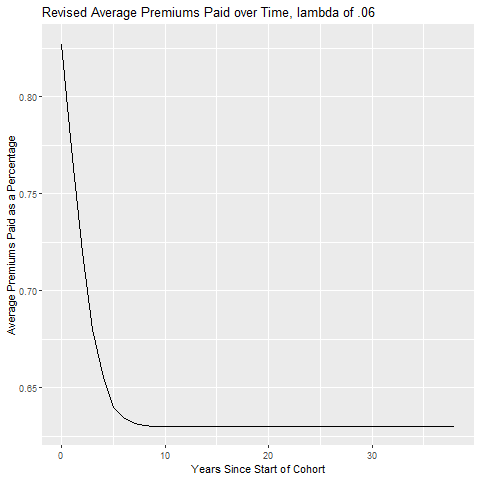

In [19]:
%%R -i ravgs1 

rplot1 <- ggplot(ravgs1) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Revised Average Premiums Paid over Time, lambda of .06') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(rplot1)

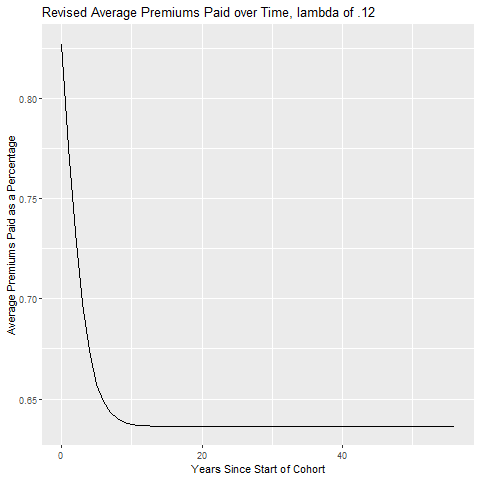

In [20]:
%%R -i ravgs2

rplot2 <- ggplot(ravgs2) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Revised Average Premiums Paid over Time, lambda of .12') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(rplot2)

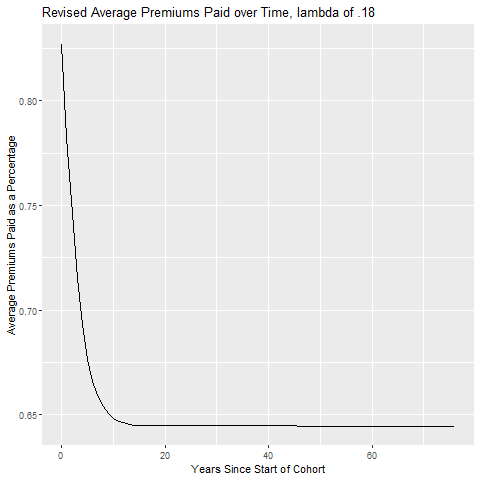

In [21]:
%%R -i ravgs3

rplot3 <- ggplot(ravgs3) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Revised Average Premiums Paid over Time, lambda of .18') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(rplot3)

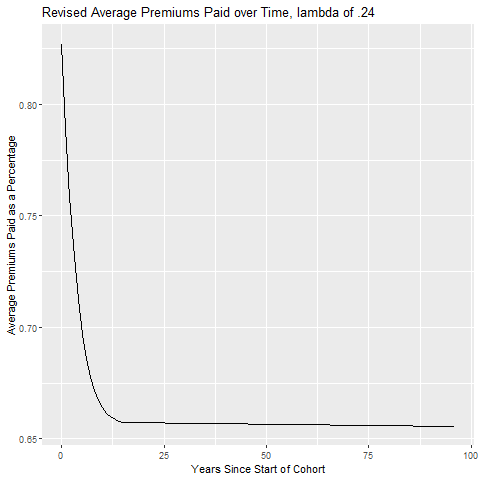

In [22]:
%%R -i ravgs4

rplot4 <- ggplot(ravgs4) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Revised Average Premiums Paid over Time, lambda of .24') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(rplot4)

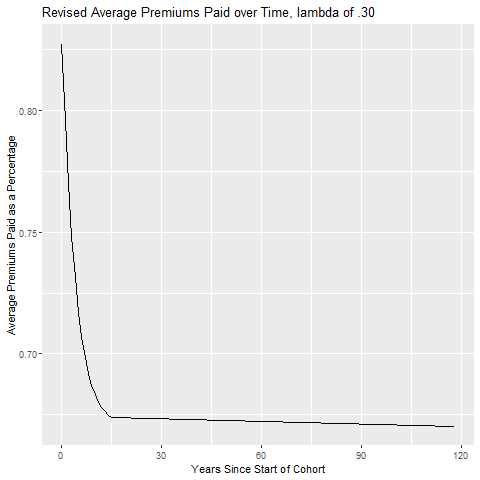

In [23]:
%%R -i ravgs5

rplot5 <- ggplot(ravgs5) +
     aes_string(x = 'years',
                y = 'average') +
     geom_line()  +
     ggtitle('Revised Average Premiums Paid over Time, lambda of .30') +
     xlab('Years Since Start of Cohort') +
     ylab('Average Premiums Paid as a Percentage')
print(rplot5)

# My Result

Now we have the results of my solution. In the graphs above we notice a similar pattern about the lambda as the original program. Below, I graph the revised program's together again and we an see that lambda affects the steepness of the curve. If we don't look too closely we might conclude that my solution may not have been that impressive. However, when looking at a new table we start to see it a little differently. When I graph my revised program's project premiums against the previous program's project premiums, a clear pattern emerges. At all values of lambda, my system generates higher levels of premiums paid. Looking at the table this is around 11% higher than the previous system.



 Years   Avg, l = .06   Avg, l = .12   Avg, l = .18   Avg, l = .24   Avg, l = .30
------  -------------  -------------  -------------  -------------  -------------
     0      0.8271250      0.8271250      0.8271250      0.8271250      0.8271250
     1      0.7682239      0.7755173      0.7825149      0.7892266      0.7956617
     2      0.7196842      0.7331550      0.7460446      0.7583628      0.7701216
     3      0.6801959      0.6979265      0.7152001      0.7319265      0.7480382
     4      0.6553294      0.6741381      0.6932801      0.7124273      0.7313143
     5      0.6399256      0.6573275      0.6764362      0.6965794      0.7171885
     6      0.6348408      0.6488845      0.6661868      0.6858146      0.7069086
     7      0.6317728      0.6430888      0.6585123      0.6772537      0.6983817
     8      0.6308334      0.6402856      0.6539183      0.6714570      0.6921416
     9      0.6302896      0.6384229      0.6505681      0.6669482      0.6870644
    10      0.

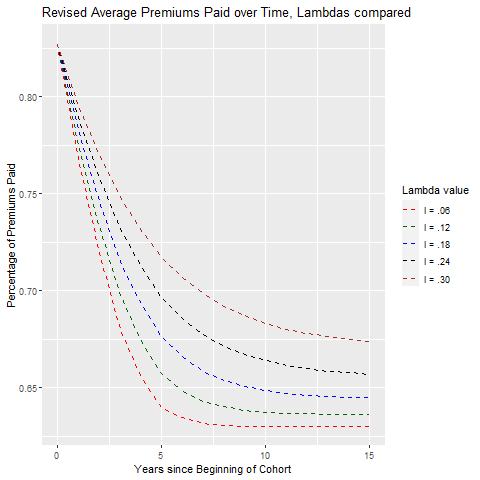

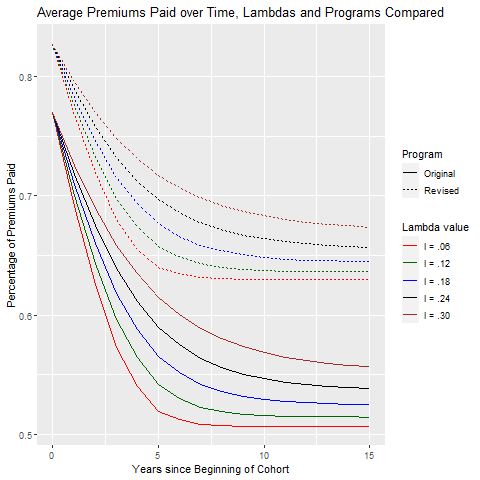

In [29]:
%%R 

ravgs12 <- merge(ravgs1,ravgs2,by="years")
ravgs34 <- merge(ravgs3,ravgs4,by="years")
ravgs1234 <- merge(ravgs12,ravgs34,by="years")
ravgsall <- merge(ravgs1234,ravgs5,by="years", col.names= c('years','l06','l12','l18','l24','l30'))

colnames(ravgsall) <- c('years','l06','l12','l18','l24','l30')

revtable <- kable(ravgsall,'simple', 
            col.names = c('Years', 'Avg, l = .06', 'Avg, l = .12', 'Avg, l = .18', 'Avg, l = .24', 'Avg, l = .30'))

print(revtable)

ggravgsall <- melt(ravgsall,id.var='years')

rplot6 <- ggplot(ggravgsall, aes(x=years, y=value, col=variable)) +
          geom_line(linetype='dashed')+
          labs(title='Revised Average Premiums Paid over Time, Lambdas compared',
               x='Years since Beginning of Cohort', y='Percentage of Premiums Paid',
               col='Lambda value') +
         scale_color_manual(labels = lambs, values = cols)
print(rplot6)

lambs <- c('l = .06', 'l = .12', 'l = .18', 'l = .24', 'l = .30', 'l = .06', 'l = .12', 'l = .18', 'l = .24', 'l = .30')
cols <- c('red', 'dark green', 'blue', 'black', 'brown', 'red', 'dark green', 'blue', 'black', 'brown')

allplot <- ggplot() +
           geom_line(data=ggavgsall, aes(x=years, y=value, col=variable, linetype='a'))+
           geom_line(data=ggravgsall, aes(x=years, y=value, col=variable, linetype='b'))+
           labs(title='Average Premiums Paid over Time, Lambdas and Programs Compared',
                x='Years since Beginning of Cohort', y='Percentage of Premiums Paid',
                col='Lambda value', style='Program') +
           scale_color_manual(labels = lambs, values = cols) +
           scale_linetype_discrete(name='Program', labels = c('Original', 'Revised'))
print(allplot)

# Reflection

My goals for this project were to develop a better understanding of Markov Chains, to hone my coding skills, and to build something I could share with potential employers. This was my first time building a project in Jupyter Notebook with the intent to share it somewhat publicly, and I feel like it went well. However, I feel the scope may have been limited.

So far in this project I've made several assumptions that simplify the process. Over time I would like to expand this project by relaxing these assumptions. The first thing that comes to mind is that I could test whether in this data set there is a different lambda for every category of driver, and whether the difference is statistically significant. Once I have that information it would be a relatively simple process to develop a more nuanced model as the way I set up my code, the calculation is basically runnable as a single callable function. I could expand this project to examine the total premiums collected across each individual category of driver, for instance. Additionally, as we are given the data for 15 years worth of accidents, it would be interesting to test my expected value of the model against what happened in those 15 years to compare the theoretical and experimental results. It's not terribly difficult to pull threads at the simplicity of the premise of the project, but one has to start somewhere! I figured this was sufficiently complex as to be talked about, but simple enough that I could accomplish the scope in a reasonable time frame.

That being said, I do think I have accoplished my original three goals. I got to explore Markov Chains, I got to work with Python and R to build a program that accomplishes something, and now I have a project I can share publicly. If you're interested, I also wrote up a summary complete with graphics that would be targeted toward someone less interested in the how of the math and more interested in the results. Thank you for your interest and time! 